In [1]:
from os.path import join
from os import getcwd
from tensorflow import keras
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard
from keras.optimizers.schedules import ExponentialDecay
from keras.initializers import GlorotNormal
from keras.regularizers import l1, l2

In [4]:
from functions import *
checkpoints_path = getcwd()+'\\checkpoints'

### Recoleccion de los datos y reemplazo de las variables categóricas

In [5]:
df = pd.read_csv('../../databases/insurance.csv')
x_df = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
y_df = df['charges']
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
x_df_edit = x_df.copy()
replace = {
    'sex': {'female':1, 'male':0},
    'smoker':{'yes':1, 'no':0}
}
x_df_edit = x_df_edit.replace(replace)
x_df_edit.head()

,age,sex,bmi,children,smoker,region
0,19,1,27.900,0,1,southwest
1,18,0,33.770,1,0,southeast
2,28,0,33.000,3,0,southeast
3,33,0,22.705,0,0,northwest
4,32,0,28.880,0,0,northwest


In [8]:
x_df_encoded = pd.get_dummies(x_df_edit, columns=['region'])
x_df_encoded.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,1,27.900,0,1,0,0,0,1
1,18,0,33.770,1,0,0,0,1,0
2,28,0,33.000,3,0,0,0,1,0
3,33,0,22.705,0,0,0,1,0,0
4,32,0,28.880,0,0,0,1,0,0


In [9]:
# Split dataset into 15% test, 85% train_validation 
x, x_test, y, y_test = train_test_split(x_df_encoded, y_df, test_size=0.15)

### Features Polinomiales

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.15)

In [11]:
max_poly_order = 10

### Priemro se realizan pruebas con parámetros por defecto para observar como evoluciona segun el orden utilizado

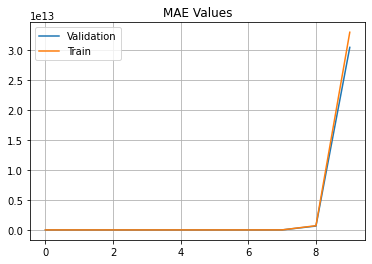

Wall time: 3min 17s


In [12]:
%%time
train_score = [3000]
validation_score = [3000]
all_metrics = {}

for i in range(2,max_poly_order+1):
    name = 'poly_order_{}'.format(i)
    file_dir = join(checkpoints_path, name)
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train)
    pol_x_valid = poly.fit_transform(x_valid)
    
    poly_checkpoint_callback = ModelCheckpoint(filepath=file_dir,
                                                  save_weights_only=True,
                                                  monitor='loss',
                                                  mode='min',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='linear', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=Adam(), loss='mae', metrics=['mae', 'mse'])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(file_dir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['MAE'][0])
    validation_score.append(metrics['MAE'][1])
    clear_output(wait=True)
    
plt.plot(validation_score, label='Validation')
plt.plot(train_score, label='Train')
plt.title('MAE Values')
plt.legend(loc='best')
plt.grid()
plt.show()

### Es posible observar como a partir del 7mo orden el optimizador diverge con los parametros actuales

### Normalización de datos

In [13]:
def normalize(dataframe, cols=[], norm_info=None):
    replace = {}
    data = dataframe.copy()
    if norm_info:
        replace=norm_info
    else:
        if len(cols)==0:
            cols = dataframe.keys()
        for col in cols:
            replace[col] = [np.mean(dataframe[col]), np.std(dataframe[col])]
    for key in replace:
        data[key] = (data[key]-replace[key][0])/replace[key][1]
    return data, replace

In [14]:
x_train_n, norm = normalize(x_train, ['age', 'bmi'], None) 
x_valid_n, norm = normalize(x_valid, ['age', 'bmi'], norm)
x_test_n, norm =  normalize(x_test, ['age', 'bmi'], norm)
x_valid_n.describe()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,-0.061925,0.508772,-0.052944,1.105263,0.204678,0.181287,0.263158,0.280702,0.274854
std,1.023443,0.501391,1.015812,1.163426,0.404651,0.386387,0.441641,0.450662,0.447752
min,-1.529289,0.000000,-2.225806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.956250,0.000000,-0.700913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.168323,1.000000,-0.081192,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.834494,1.000000,0.509570,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.765682,1.000000,2.867652,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


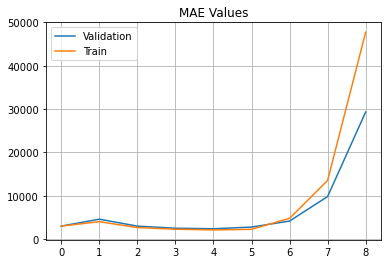

Wall time: 3min 17s


In [15]:
%%time
train_score = [3000]
validation_score = [3000]
all_metrics = {}

for i in range(2,10):
    name = 'poly_order_{}b'.format(i)
    file_dir = join(checkpoints_path, name)
    poly = PolynomialFeatures(degree=i)
    pol_x_train = poly.fit_transform(x_train_n)
    pol_x_valid = poly.fit_transform(x_valid_n)
    
    poly_checkpoint_callback = ModelCheckpoint(filepath=file_dir,
                                                  save_weights_only=True,
                                                  monitor='loss',
                                                  mode='min',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='linear', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=Adam(1), loss='mae', metrics=['mae', 'mse'])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(file_dir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['MAE'][0])
    validation_score.append(metrics['MAE'][1])
    clear_output(wait=True)
    
plt.plot(validation_score, label='Validation')
plt.plot(train_score, label='Train')
plt.title('MAE Values')
plt.legend(loc='best')
plt.grid()
plt.show()

In [16]:
train_score

[3000,
 4012.1926206322782,
 2665.6074293358165,
 2279.298740674354,
 2118.6072999188423,
 2260.1605417590863,
 4792.9967396612365,
 13530.139449798744,
 47726.37140057342]

### Normalizando los datos que corresponden a variables continuas se puede evidencias una mejora en la performance de los ordenes mas bajos, respetandose lo visto anteriormente que el modelo empeora considerablemente al superar el orden 7

In [17]:
all_metrics[5]

,Set,MAE,MSE
0,Train,2118.607300,3.050975e+07
1,Validacion,2385.720536,2.662478e+07


### Para continuar desarrollando el modelo se utilizará el orden 5 el cual obtuvo la mejor métrica, es interesante observar como se puede evidenciar cierto grado de overfitting en este modelo, lo cual puede deberse a los pocos datos disponibles y al orden polinomial utilizado

In [18]:
poly = PolynomialFeatures(degree=5)
pol_x_train = poly.fit_transform(x_train_n)
pol_x_valid = poly.fit_transform(x_valid_n)

### Learning rate optimo

In [19]:
%%time
train_score = []
validation_score = []
all_metrics = {}
lr_s = [0.05, 0.1, 0.5, 0.85, 1.0, 1.5, 2.0, 2.5]
for i in lr_s:
    name = 'poly_order_lr{}b'.format(i)
    file_dir = join(checkpoints_path, name)

    poly_checkpoint_callback = ModelCheckpoint(filepath=file_dir,
                                                  save_weights_only=True,
                                                  monitor='loss',
                                                  mode='min',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='linear', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=Adam(lr=i), loss='mae', metrics=['mae', 'mse'])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(file_dir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['MAE'][0])
    validation_score.append(metrics['MAE'][1])
    clear_output(wait=True)


Wall time: 3min 41s


In [20]:
for i in range(len(lr_s)):
    print('lr={}, MAE_train={}, MAE_valid={}'.format(lr_s[i], train_score[i], validation_score[i]))

lr=0.05, MAE_train=6509.031057460715, MAE_valid=7102.042931142863
lr=0.1, MAE_train=5016.5986243866855, MAE_valid=5610.342789273175
lr=0.5, MAE_train=2559.000733365804, MAE_valid=2922.4963460631398
lr=0.85, MAE_train=2240.078034449627, MAE_valid=2509.8013404870253
lr=1.0, MAE_train=2135.949893923497, MAE_valid=2420.7783181231725
lr=1.5, MAE_train=2065.666804792152, MAE_valid=2585.3261897092016
lr=2.0, MAE_train=2027.9137408952834, MAE_valid=2446.5391360508042
lr=2.5, MAE_train=1950.4395663970708, MAE_valid=2560.6619155715466


### El mejor learning rate obtenido es 1.5 (Podemos observar como se puede inferir que el overfitting es mayor por el aumento en la diferencia de las metricas de train y validación)

In [21]:
%%time
train_score = []
validation_score = []
all_metrics = {}
beta_1 = [0.8, 0.85, 0.9, 0.95, 0.99, 0.999]
for i in beta_1:
    name = 'order_6_beta{}b'.format(i)
    file_dir = join(checkpoints_path, name)

    poly_checkpoint_callback = ModelCheckpoint(filepath=file_dir,
                                                  save_weights_only=True,
                                                  monitor='loss',
                                                  mode='min',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='linear', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=Adam(lr=1.5, beta_1=i), loss='mae', metrics=['mae', 'mse'])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(file_dir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['MAE'][0])
    validation_score.append(metrics['MAE'][1])
    clear_output(wait=True)

for i in range(len(beta_1)):
    print('beta_1={}, MAE_train={}, MAE_valid={}'.format(beta_1[i], train_score[i], validation_score[i]))

beta_1=0.8, MAE_train=2009.4269633608308, MAE_valid=2514.233302066429
beta_1=0.85, MAE_train=2039.5723598592579, MAE_valid=2540.8361700426035
beta_1=0.9, MAE_train=1944.166252872792, MAE_valid=2432.805199590187
beta_1=0.95, MAE_train=1961.6908209725593, MAE_valid=2451.5384204269462
beta_1=0.99, MAE_train=1930.3294040404212, MAE_valid=2377.287628491868
beta_1=0.999, MAE_train=2227.354775601324, MAE_valid=2696.1969479894237
Wall time: 2min 42s


In [22]:
%%time
train_score = []
validation_score = []
all_metrics = {}
beta_2 = [0.8, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999]
for i in beta_2:
    name = 'order_6_beta2_{}b'.format(i)
    file_dir = join(checkpoints_path, name)

    poly_checkpoint_callback = ModelCheckpoint(filepath=file_dir,
                                                  save_weights_only=True,
                                                  monitor='loss',
                                                  mode='min',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='linear', input_shape=(pol_x_train.shape[1],)))
    poly_model.compile(optimizer=Adam(lr=1.5, beta_1=0.99, beta_2=i), loss='mae', metrics=['mae', 'mse'])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(file_dir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[i] = metrics
    train_score.append(metrics['MAE'][0])
    validation_score.append(metrics['MAE'][1])
    clear_output(wait=True)

for i in range(len(beta_2)):
    print('beta_2={}, MAE_train={}, MAE_valid={}'.format(beta_2[i], train_score[i], validation_score[i]))

beta_2=0.8, MAE_train=2027.5597718718861, MAE_valid=2596.973353596948
beta_2=0.85, MAE_train=2031.568492077025, MAE_valid=2599.818664586417
beta_2=0.9, MAE_train=2187.4141812436515, MAE_valid=2657.560646922058
beta_2=0.95, MAE_train=1946.836550671988, MAE_valid=2398.583117408169
beta_2=0.99, MAE_train=1989.771197876957, MAE_valid=2450.776123007128
beta_2=0.999, MAE_train=1935.7142521969827, MAE_valid=2412.4367383899853
beta_2=0.9999, MAE_train=1974.2260195107483, MAE_valid=2416.130431841877
Wall time: 2min 36s


### Correccion de overfittign
#### Como se menciono previamente cada vez que se fue optimizando el modelo el overfitting del mismo fue en aumento con lo cual, para corregirlo se buscará utilizar regularización L1 o L2

In [23]:
%%time
train_score = []
validation_score = []
all_metrics = {}
for reg in ['l1', 'l2']:
    print(reg)
    name = 'order_6_reg_{}b'.format(i)
    file_dir = join(checkpoints_path, name)

    poly_checkpoint_callback = ModelCheckpoint(filepath=file_dir,
                                                  save_weights_only=True,
                                                  monitor='loss',
                                                  mode='min',
                                                  save_best_only=True)
    
    poly_model = Sequential()
    poly_model.add(Dense(units=1, activation='linear', input_shape=(pol_x_train.shape[1],), kernel_regularizer=reg))
    poly_model.compile(optimizer=Adam(lr=1.5, beta_1=0.99, beta_2=0.95), loss='mae', metrics=['mae', 'mse'])

    history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback], 
                             verbose=1)
    
    # Cargo el mejor modelo entrenado
    poly_model.load_weights(file_dir)
    metrics = verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)
    # Guardo las metricas de cada orden para comparar
    all_metrics[reg] = metrics
    train_score.append(metrics['MAE'][0])
    validation_score.append(metrics['MAE'][1])
    clear_output(wait=True)

all_metrics

Wall time: 54.1 s


{'l1':           Set          MAE           MSE
 0       Train  2147.523446  3.144649e+07
 1  Validacion  2370.439038  2.766421e+07,
 'l2':           Set          MAE           MSE
 0       Train  7646.660274  1.882918e+08
 1  Validacion  8182.561299  1.614017e+08}

Podemos observar como al utilizar regularización l1 disminuye la diferencia entre la metrica de train y validacion, reduciendo de esta forma el overffiting

In [24]:
name = 'final'
file_dir = join(checkpoints_path, name)

poly_checkpoint_callback = ModelCheckpoint(filepath=file_dir,
                                              save_weights_only=True,
                                              monitor='loss',
                                              mode='min',
                                              save_best_only=True)

poly_model = Sequential()
poly_model.add(Dense(units=1, activation='linear', input_shape=(pol_x_train.shape[1],), kernel_regularizer='l1'))
poly_model.compile(optimizer=Adam(lr=1.5, beta_1=0.99, beta_2=0.95), loss='mae', metrics=['mae', 'mse'])

history = poly_model.fit(pol_x_train, y_train, epochs=100, validation_data=(pol_x_valid, y_valid), callbacks=[poly_checkpoint_callback], 
                         verbose=1)

# Cargo el mejor modelo entrenado
poly_model.load_weights(file_dir)
verify_model(poly_model, pol_x_train, y_train, pol_x_valid, y_valid)

Epoch 1/100
31/31 [==============================] - 1s 17ms/step - loss: 11168.6494 - mae: 11057.5811 - mse: 254016896.0000 - val_loss: 9975.7119 - val_mae: 9774.4863 - val_mse: 218564336.0000
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 9057.0869 - mae: 8787.9102 - mse: 170393936.0000 - val_loss: 9185.5098 - val_mae: 8841.3906 - val_mse: 177987888.0000
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 8144.2275 - mae: 7739.5229 - mse: 141501216.0000 - val_loss: 8234.2588 - val_mae: 7768.6475 - val_mse: 142852080.0000
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 7520.7432 - mae: 7016.9863 - mse: 122301616.0000 - val_loss: 7461.7324 - val_mae: 6921.2910 - val_mse: 120049696.0000
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 7085.4668 - mae: 6517.8569 - mse: 127202920.0000 - val_loss: 6843.9409 - val_mae: 6248.9980 - val_mse: 103942168.0000
Epoch 6/100
31/31 [======================

,Set,MAE,MSE
0,Train,2231.200609,3.162229e+07
1,Validacion,2428.358910,2.819805e+07


### Probando el modelo sobre test

In [25]:
pol_x_test = poly.fit_transform(x_test_n)
verify_model(poly_model, pol_x_train, y_train, pol_x_test, y_test, valid_label='Tets')

,Set,MAE,MSE
0,Train,2231.200609,3.069449e+07
1,Tets,2472.166666,2.819805e+07
